# End of Day Reversal - Part 3

Reiteration of the backtest using a different perspective:
- Trade directly on SPY. 
- Each day at 15:30 we retrieve the list of ROD3 over the last 30 days.
- If today ROD3 is below the 10% worst percentile, then we buy.
- We still assume we can close our position at 15:59:59. If results OOS are decent, then we make backtesting more realistic before doing IS. 

In [ ]:
import pandas as pd
import numpy as np
from itertools import product
import matplotlib.pyplot as plt
plt.style.use("dark_background")
from backtesting import Backtest, Strategy
from tqdm import tqdm
from concurrent.futures import ProcessPoolExecutor, as_completed
import os

/home/edoardo/Nextcloud/Development/3 - Trading/z - Library/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/edoardo/Nextcloud/Development/3 - Trading/z - Library/.venv/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
main_df = pd.read_csv('SPY 2017-10-18_5325-02-25 30m.csv')
main_df.set_index('Datetime', inplace=True)
main_df.index = pd.to_datetime(main_df.index)   

def get_last_rod3(df, observations = None):
    '''
    - df
    - observatiions : how many days of ROD3 to retrieve. Set to None to get all
    '''
    # Build a single aligned DataFrame and drop days missing either value
    yesterday_close = df['Close'].at_time('16:00').shift(1)
    close_minus_60 =  df['Close'].at_time('15:00')
    # Here timestamps refers to candle close
    if len(yesterday_close) != len(close_minus_60):
        #print(f"🔴 {len(yesterday_close)} prices of yesterday at 15:59 (market close).")
        #print(f"🔴 {len(close_minus_60)} prices at 14:59.")

        # Store a list of all the dates where we have both yesterday close and price at 15:00
        common_dates = yesterday_close.index.normalize().intersection(close_minus_60.index.normalize())
        yesterday_close = yesterday_close[yesterday_close.index.normalize().isin(common_dates)]
        close_minus_60 = close_minus_60[close_minus_60.index.normalize().isin(common_dates)]

    rod3 = (( close_minus_60  / yesterday_close.values ) - 1).rename('ROD3')
    if observations is None:
        return rod3
    else:
        return rod3.tail(observations)

main_df['ROD3'] = get_last_rod3(main_df)


Start                     2017-10-18 15:30:00
End                       2023-12-29 16:00:00
Duration                   2263 days 00:30:00
Exposure Time [%]                     2.34028
Equity Final [$]                      9264.73
Equity Peak [$]                      10072.06
Return [%]                            -7.3527
Buy & Hold Return [%]                85.76732
Return (Ann.) [%]                     -1.2261
Volatility (Ann.) [%]                 2.43068
CAGR [%]                             -0.84682
Sharpe Ratio                         -0.50442
Sortino Ratio                        -0.65081
Calmar Ratio                         -0.15296
Alpha [%]                            -8.79871
Beta                                  0.01686
Max. Drawdown [%]                    -8.01554
Avg. Drawdown [%]                    -4.05909
Max. Drawdown Duration     2173 days 00:30:00
Avg. Drawdown Duration     1097 days 12:30:00
# Trades                                  158
Win Rate [%]                      

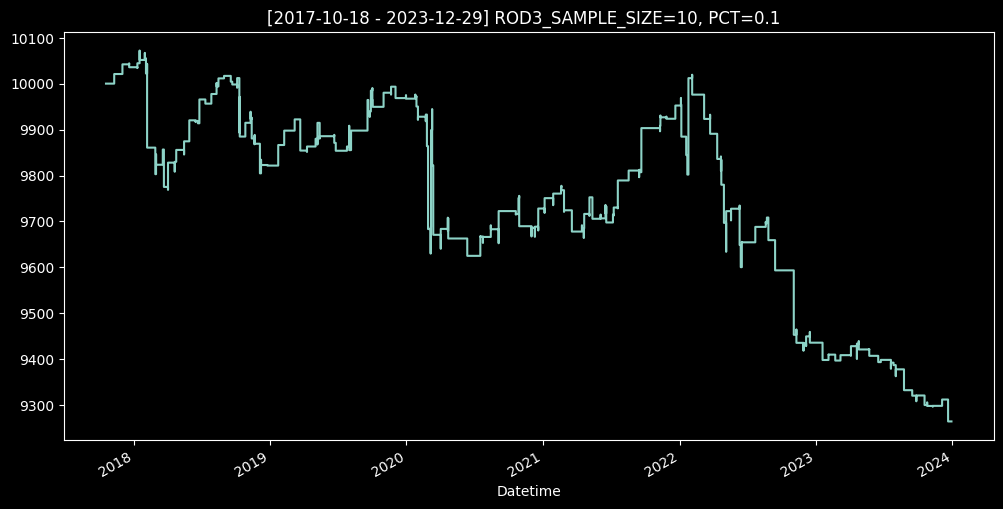

In [4]:
# Cutting out data
df = main_df[main_df.index.year < 2024].copy()
LOG_FILENAME = 'backtest#1_log.txt'

def log(text : str, console = False):
    if not console:
        with open(LOG_FILENAME, "a") as f:
            f.write(text+'\n')
    else:
        print(text)
        

class EndOfDayReversal(Strategy):

    ROD3_SAMPLE_SIZE = 10
    PCT = 0.1

    def init(self):
        log('=='*50+f'\n🏁 BACKTEST STARTED\nROD3_PERIOD={self.ROD3_SAMPLE_SIZE}, PCT={self.PCT}.\n')

    def next(self):
        
        today_date = self.data.index[-1]
        buy_time = today_date.strftime('%H:%M') == '15:00'
        close_time = today_date.strftime('%H:%M') == '16:00'
        
        # If it's time to buy (i.e. we have the ROD3 for the day)
        if buy_time:
            rod3_values = self.data.df.ROD3.dropna().copy().tail(self.ROD3_SAMPLE_SIZE)
            
            # If the amount of ROD3 observation is enough for the input
            if len(rod3_values) >= self.ROD3_SAMPLE_SIZE:
                # Check existence
                if today_date not in rod3_values.index:
                    print(f'[{today_date}] ERROR: No ROD3 entry.')
                
                rod3_values = rod3_values.to_frame('ROD3')
                rod3_values['rank'] = rod3_values['ROD3'].rank(pct=True)
                today_rod3 = rod3_values.loc[today_date] 
                
                log(f'➡️ [{today_date}] ROD3={today_rod3['ROD3']} | PCT={today_rod3['rank']}.')

                if today_rod3['rank'] <= self.PCT:
                    self.buy()
                    log('\t🟢Trade opened.')

        if self.position and close_time:
            self.position.close()

# Assuming we can open and close trades using Close price of OHLC data.
# Done for the sake of simplicity.
bt = Backtest(df, EndOfDayReversal, trade_on_close=True)
stats = bt.run()

print(stats)
title=f'[{df.index[0].date()} - {df.index[-1].date()}] ROD3_SAMPLE_SIZE={stats._strategy.ROD3_SAMPLE_SIZE}, PCT={stats._strategy.PCT}  '
stats._equity_curve['Equity'].plot(figsize=(12, 6), title=title)
plt.show()

## Optimization

We try to optimize the In-Sample backtest in order to see if there is a certain combination of parameters that yeld better results. If so, we'll validate it with the Out-Of-Sample dataset.

In [5]:
df = main_df[main_df.index.year < 2024].copy()
params_list = list(product(range(10, 252, 10), np.arange(0.05, 1.0, 0.05)))

bt = Backtest(
    data=df,
    strategy=EndOfDayReversal,
    cash=10_000,
    finalize_trades=True,
    trade_on_close=True
)

# Multi-thread approach
def do_backtest(args):
    rod3_sample_size, pct = args
    stats = bt.run(ROD3_SAMPLE_SIZE=rod3_sample_size, PCT=pct)
    avg_trade = stats._trades.PnL.mean()
    return {
        "ROD3_SAMPLE_SIZE": rod3_sample_size,
        "PCT": pct,
        "Equity Final [$]": round(stats["Equity Final [$]"], 2),
        "Winrate": round(stats["Win Rate [%]"], 2),
        "Average Trade": round(avg_trade, 2),
        '#Trades' : len(stats._trades),
    }

rows = []
# use all available cores/threads, leaving 2 free
cores_to_use = os.cpu_count()-2
with ProcessPoolExecutor(max_workers=cores_to_use) as executor:
    # create a list of actions (i.e. functions to execute) to do in a multi-threaded fashion
    futures = [executor.submit(do_backtest, args) for args in params_list]
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Backtesting", unit='backtest'):
        rows.append(fut.result())

display(pd.DataFrame(rows).sort_values(by='Average Trade', ascending=False))

Backtesting: 100%|██████████| 475/475 [00:52<00:00,  9.09backtest/s]


,ROD3_SAMPLE_SIZE,PCT,Equity Final [$],Winrate,Average Trade,#Trades
230,130,0.15,9956.44,50.00,-0.21,210
191,110,0.20,9916.88,49.83,-0.28,293
212,120,0.20,9798.17,49.83,-0.69,291
211,120,0.15,9846.38,50.47,-0.72,214
232,130,0.20,9794.10,48.94,-0.73,282
...,...,...,...,...,...,...
94,60,0.05,8995.81,43.42,-13.21,76
247,140,0.05,8947.00,35.14,-14.23,74
113,70,0.05,8971.52,42.65,-15.12,68
70,50,0.05,8883.54,40.30,-16.66,67


All backtests have a negative result. Let's try two different tests with the same percentile approach:

1. we sell when the day has been too good.
2. we sell when the day has been too bad.
3. we buy when the day has been too good.

## Backtest second logic

In [6]:
# Cutting out data
df = main_df[main_df.index.year < 2024].copy()
LOG_FILENAME = 'backtest#1_log.txt'

def log(text : str, console = False):
    if not console:
        with open(LOG_FILENAME, "a") as f:
            f.write(text+'\n')
    else:
        print(text)
        

class EndOfDayReversal_v2(Strategy):

    ROD3_SAMPLE_SIZE = 10
    PCT = 0.1
    SIDE = 'buy' # or 'sell'
    PICK = 'worst' # or 'best'

    def init(self):
        assert self.SIDE in ['buy','sell'], 'SIDE parameter must be either "buy" or "sell"'
        assert self.PICK in ['worst', 'best'], 'PICK parameter must be either "worst" or "best"'
        assert self.PCT <= 1 and self.PCT > 0 , 'PCT must be in (0,1]'
        # log('=='*50+f'\n🏁 BACKTEST STARTED\nROD3_PERIOD={self.ROD3_SAMPLE_SIZE}, PCT={self.PCT}.\n')

    def next(self):
        
        today_date = self.data.index[-1]
        trade_time = today_date.strftime('%H:%M') == '15:00'
        close_time = today_date.strftime('%H:%M') == '16:00'
        
        # If it's time to buy (i.e. we have the ROD3 for the day)
        if trade_time:
            rod3_values = self.data.df.ROD3.dropna().copy().tail(self.ROD3_SAMPLE_SIZE)
            
            # If the amount of ROD3 observation is enough for the input
            if len(rod3_values) >= self.ROD3_SAMPLE_SIZE:
                # Check existence
                if today_date not in rod3_values.index:
                    print(f'[{today_date}] ERROR: No ROD3 entry.')
                
                rod3_values = rod3_values.to_frame('ROD3')
                rod3_values['rank'] = rod3_values['ROD3'].rank(pct=True)
                today_rod3 = rod3_values.loc[today_date] 
                
                log(f'➡️ [{today_date}] ROD3={today_rod3['ROD3']} | PCT={today_rod3['rank']}.')

                rod3_leq_pct = today_rod3['rank'] <= self.PCT
                rod3_geq_pct = today_rod3['rank'] >= self.PCT

                # If PICK = 'worst' then we buy if ROD3 is below the PCT
                # If PICK = 'best' then we buy if ROD3 is above the PCT
                trade_open =  rod3_leq_pct if self.PICK == 'worst' else rod3_geq_pct
                # If the strategy consist in buying
                if self.SIDE == 'buy' and trade_open:
                    self.buy()
                    # log('\t🟢Trade opened.')

                # If the strategy consist in selling
                elif self.SIDE == 'sell' and trade_open:
                    self.sell()
                    # log('\t🟢Trade opened.')

        if self.position and close_time:
            self.position.close()

### Optimization 1: sell when day has been too good

- We will optimize `ROD3_SAMPLE_SIZE` and `PCT`
- We will set `SIDE='sell'` and `PICK='best'`

This way we are going to seel when $ROD3>=$ percentile.

In [7]:
df = main_df[main_df.index.year < 2024].copy()
params_list = list(product(range(10, 252, 10), np.arange(0.05, 1.0, 0.05)))

bt = Backtest(
    data=df,
    strategy=EndOfDayReversal_v2,
    cash=10_000,
    finalize_trades=True,
    trade_on_close=True
)

# Multi-thread approach
def do_backtest(args):
    rod3_sample_size, pct = args
    stats = bt.run(ROD3_SAMPLE_SIZE=rod3_sample_size, PCT=pct, SIDE='sell', PICK = 'best')
    avg_trade = stats._trades.PnL.mean()
    return {
        "ROD3_SAMPLE_SIZE": rod3_sample_size,
        "PCT": pct,
        "Equity Final [$]": round(stats["Equity Final [$]"], 2),
        "Winrate": round(stats["Win Rate [%]"], 2),
        "Average Trade": round(avg_trade, 2),
        '#Trades' : len(stats._trades),
    }

rows = []
# use all available cores/threads, leaving 2 free
cores_to_use = os.cpu_count()-2
with ProcessPoolExecutor(max_workers=cores_to_use) as executor:
    # create a list of actions (i.e. functions to execute) to do in a multi-threaded fashion
    futures = [executor.submit(do_backtest, args) for args in params_list]
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Backtesting", unit='backtest'):
        rows.append(fut.result())

display(pd.DataFrame(rows).sort_values(by='Average Trade', ascending=False))

Backtesting: 100%|██████████| 475/475 [00:51<00:00,  9.27backtest/s]


,ROD3_SAMPLE_SIZE,PCT,Equity Final [$],Winrate,Average Trade,#Trades
21,20,0.05,11365.48,50.68,0.89,1537
13,10,0.05,11304.35,50.61,0.84,1547
1,10,0.10,11304.35,50.61,0.84,1547
195,110,0.20,10798.40,50.39,0.68,1167
230,130,0.15,10810.89,50.29,0.67,1217
...,...,...,...,...,...,...
435,230,0.95,8471.47,42.42,-23.16,66
471,250,0.95,8472.78,41.54,-23.50,65
455,240,0.95,8489.50,42.86,-23.98,63
302,160,0.95,8464.96,46.88,-23.98,64


We have a positive result with the strategy that sell when $ROD3$ ranks above the 5% of the last 20 days. This is a really easy condition to be met, hence the high number of trade. Basically this strategy is selling, almost every day, on the last 30 minutes of the trading session.

Backtest.run:   0%|          | 0/20253 [00:00<?, ?bar/s]

Start                     2017-10-18 15:30:00
End                       2023-12-29 16:00:00
Duration                   2263 days 00:30:00
Exposure Time [%]                    22.75106
Equity Final [$]                     11375.14
Equity Peak [$]                      12020.32
Return [%]                            13.7514
Buy & Hold Return [%]                85.76732
Return (Ann.) [%]                     2.10316
Volatility (Ann.) [%]                 7.17596
CAGR [%]                              1.44511
Sharpe Ratio                          0.29308
Sortino Ratio                         0.41991
Calmar Ratio                          0.13328
Alpha [%]                            24.84041
Beta                                 -0.12929
Max. Drawdown [%]                   -15.78044
Avg. Drawdown [%]                    -1.13271
Max. Drawdown Duration      817 days 00:30:00
Avg. Drawdown Duration       45 days 02:02:00
# Trades                                 1536
Win Rate [%]                      

/tmp/ipykernel_343015/1329850427.py:3: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run(ROD3_SAMPLE_SIZE=20, PCT=0.05, SIDE='sell', PICK = 'best')


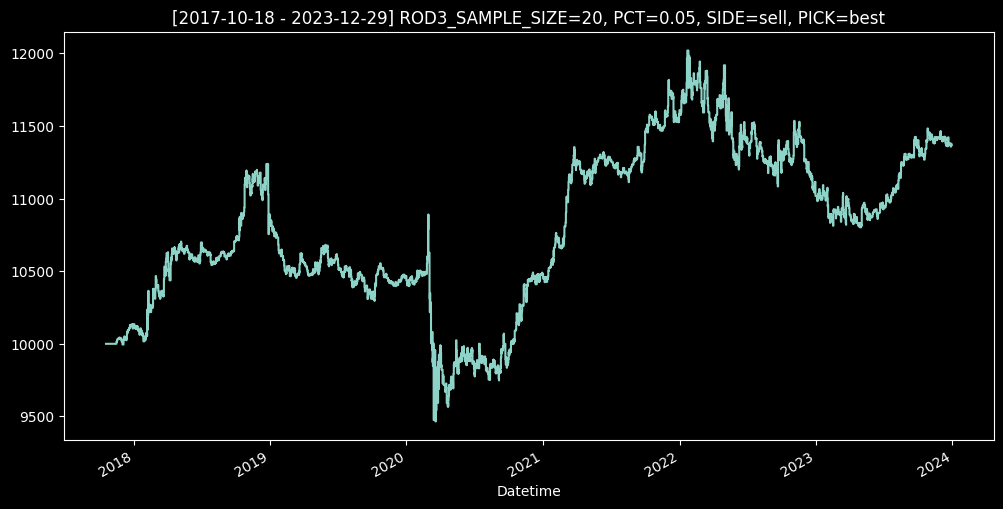

In [8]:
df = main_df[main_df.index.year < 2024].copy()
bt = Backtest(df, EndOfDayReversal_v2, trade_on_close=True)
stats = bt.run(ROD3_SAMPLE_SIZE=20, PCT=0.05, SIDE='sell', PICK = 'best')

print(stats)
title = (
    f"[{df.index[0].date()} - {df.index[-1].date()}] "
    f"ROD3_SAMPLE_SIZE={stats._strategy.ROD3_SAMPLE_SIZE}, "
    f"PCT={stats._strategy.PCT}, "
    f'SIDE={stats._strategy.SIDE}, '
    f'PICK={stats._strategy.PICK}'
)
stats._equity_curve['Equity'].plot(figsize=(12, 6), title=title)
plt.show()

Looking at the equity curve, I wont call this a consisent pattern. Let's continue with other optimizations.

### Optimization 2: sell when day has been too bad



In [9]:
df = main_df[main_df.index.year < 2024].copy()
params_list = list(product(range(10, 252, 10), np.arange(0.05, 1.0, 0.05)))

bt = Backtest(
    data=df,
    strategy=EndOfDayReversal_v2,
    cash=10_000,
    finalize_trades=True,
    trade_on_close=True
)

# Multi-thread approach
def do_backtest(args):
    rod3_sample_size, pct = args
    stats = bt.run(ROD3_SAMPLE_SIZE=rod3_sample_size, PCT=pct, SIDE='sell', PICK = 'worst')
    avg_trade = stats._trades.PnL.mean()
    return {
        "ROD3_SAMPLE_SIZE": rod3_sample_size,
        "PCT": pct,
        "Equity Final [$]": round(stats["Equity Final [$]"], 2),
        "Winrate": round(stats["Win Rate [%]"], 2),
        "Average Trade": round(avg_trade, 2),
        '#Trades' : len(stats._trades),
    }

rows = []
# use all available cores/threads, leaving 2 free
cores_to_use = os.cpu_count()-2
with ProcessPoolExecutor(max_workers=cores_to_use) as executor:
    # create a list of actions (i.e. functions to execute) to do in a multi-threaded fashion
    futures = [executor.submit(do_backtest, args) for args in params_list]
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Backtesting", unit='backtest'):
        rows.append(fut.result())

display(pd.DataFrame(rows).sort_values(by='Average Trade', ascending=False))

Backtesting: 100%|██████████| 475/475 [00:51<00:00,  9.27backtest/s]


,ROD3_SAMPLE_SIZE,PCT,Equity Final [$],Winrate,Average Trade,#Trades
72,50,0.05,11207.62,59.70,18.02,67
112,70,0.05,11069.39,57.35,15.73,68
245,140,0.05,11121.23,64.86,15.15,74
95,60,0.05,11059.27,56.58,13.94,76
266,150,0.05,10878.32,64.18,13.11,67
...,...,...,...,...,...,...
212,120,0.15,10059.87,49.53,0.28,214
211,120,0.20,10078.66,50.17,0.27,291
194,110,0.20,10000.98,50.17,0.00,293
233,130,0.15,9949.43,50.00,-0.24,210


Start                     2017-10-18 15:30:00
End                       2023-12-29 16:00:00
Duration                   2263 days 00:30:00
Exposure Time [%]                      0.9924
Equity Final [$]                     11207.62
Equity Peak [$]                      11237.26
Return [%]                            12.0762
Buy & Hold Return [%]                85.76732
Return (Ann.) [%]                     1.85874
Volatility (Ann.) [%]                 2.79857
CAGR [%]                              1.27764
Sharpe Ratio                          0.66418
Sortino Ratio                          1.2608
Calmar Ratio                           0.4989
Alpha [%]                            13.61843
Beta                                 -0.01798
Max. Drawdown [%]                    -3.72565
Avg. Drawdown [%]                    -1.12957
Max. Drawdown Duration      799 days 00:00:00
Avg. Drawdown Duration      177 days 10:03:00
# Trades                                   67
Win Rate [%]                      

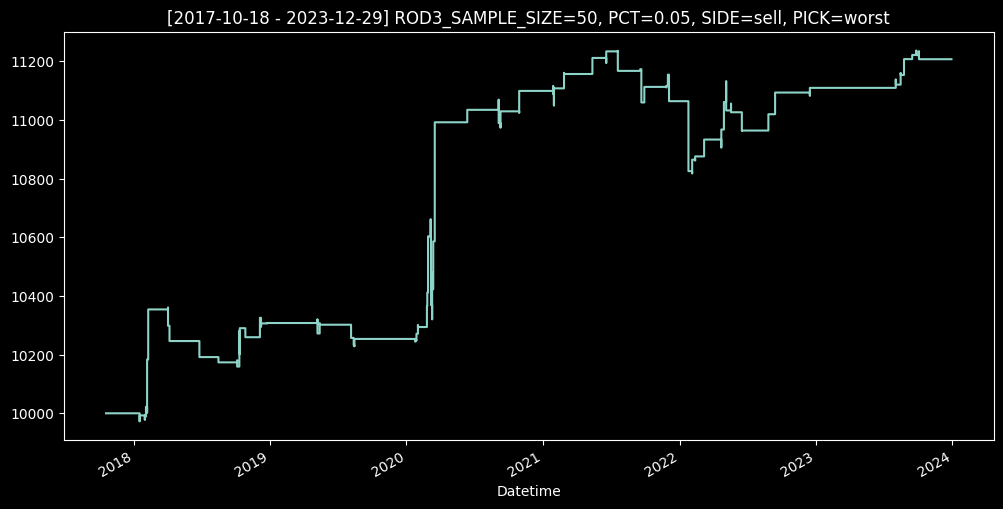

In [10]:
df = main_df[main_df.index.year < 2024].copy()

bt = Backtest(df, EndOfDayReversal_v2, trade_on_close=True)
stats = bt.run(ROD3_SAMPLE_SIZE=50, PCT=0.05, SIDE='sell', PICK = 'worst')

print(stats)
title = (
    f"[{df.index[0].date()} - {df.index[-1].date()}] "
    f"ROD3_SAMPLE_SIZE={stats._strategy.ROD3_SAMPLE_SIZE}, "
    f"PCT={stats._strategy.PCT}, "
    f'SIDE={stats._strategy.SIDE}, '
    f'PICK={stats._strategy.PICK}'
)
stats._equity_curve['Equity'].plot(figsize=(12, 6), title=title)
plt.show()

This strategy sells when ROD3 ranks below the 5% of the last 50 days observations. 

The overall results and equity curve shape does not seems to change with configurations that has more trades, for example the one with `ROD3_SAMPLE_SIZE=20, PCT=0.1` that has more executed trades:

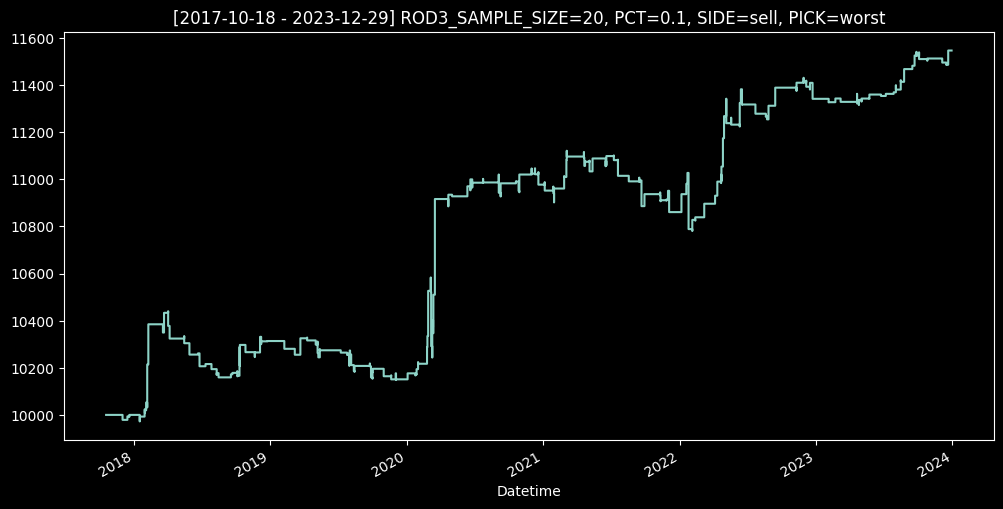

So we can say that the best configuration despite having a smaller amount of trades is not mere luck because the one with more trades do not differ that much. Of course everything will be confirmed or denied in the OOS test.

### Optimization 3: buy when the day has been too good.

In [11]:
df = main_df[main_df.index.year < 2024].copy()
params_list = list(product(range(10, 252, 10), np.arange(0.05, 1.0, 0.05)))

bt = Backtest(
    data=df,
    strategy=EndOfDayReversal_v2,
    cash=10_000,
    finalize_trades=True,
    trade_on_close=True
)

# Multi-thread approach
def do_backtest(args):
    rod3_sample_size, pct = args
    stats = bt.run(ROD3_SAMPLE_SIZE=rod3_sample_size, PCT=pct, SIDE='buy', PICK = 'best')
    avg_trade = stats._trades.PnL.mean()
    return {
        "ROD3_SAMPLE_SIZE": rod3_sample_size,
        "PCT": pct,
        "Equity Final [$]": round(stats["Equity Final [$]"], 2),
        "Winrate": round(stats["Win Rate [%]"], 2),
        "Average Trade": round(avg_trade, 2),
        '#Trades' : len(stats._trades),
    }

rows = []
# use all available cores/threads, leaving 2 free
cores_to_use = os.cpu_count()-2
with ProcessPoolExecutor(max_workers=cores_to_use) as executor:
    # create a list of actions (i.e. functions to execute) to do in a multi-threaded fashion
    futures = [executor.submit(do_backtest, args) for args in params_list]
    for fut in tqdm(as_completed(futures), total=len(futures), desc="Backtesting", unit='backtest'):
        rows.append(fut.result())

display(pd.DataFrame(rows).sort_values(by='Average Trade', ascending=False))

Backtesting: 100%|██████████| 475/475 [00:52<00:00,  9.03backtest/s]


,ROD3_SAMPLE_SIZE,PCT,Equity Final [$],Winrate,Average Trade,#Trades
417,220,0.95,11708.50,57.14,27.12,63
454,240,0.95,11696.52,57.14,26.93,63
303,160,0.95,11721.51,53.12,26.90,64
472,250,0.95,11723.53,58.46,26.52,65
436,230,0.95,11729.75,57.58,26.21,66
...,...,...,...,...,...,...
230,130,0.15,9084.02,48.97,-0.75,1217
193,110,0.20,9079.69,48.84,-0.79,1167
10,10,0.10,8551.14,48.80,-0.94,1547
2,10,0.05,8551.14,48.80,-0.94,1547


Start                     2017-10-18 15:30:00
End                       2023-12-29 16:00:00
Duration                   2263 days 00:30:00
Exposure Time [%]                     1.02202
Equity Final [$]                     11590.97
Equity Peak [$]                       11661.9
Return [%]                            15.9097
Buy & Hold Return [%]                85.76732
Return (Ann.) [%]                     2.41364
Volatility (Ann.) [%]                 3.42831
CAGR [%]                              1.65766
Sharpe Ratio                          0.70403
Sortino Ratio                         1.63192
Calmar Ratio                          0.77994
Alpha [%]                            13.72962
Beta                                  0.02542
Max. Drawdown [%]                    -3.09467
Avg. Drawdown [%]                    -1.08062
Max. Drawdown Duration      795 days 01:00:00
Avg. Drawdown Duration      221 days 15:45:00
# Trades                                   69
Win Rate [%]                      

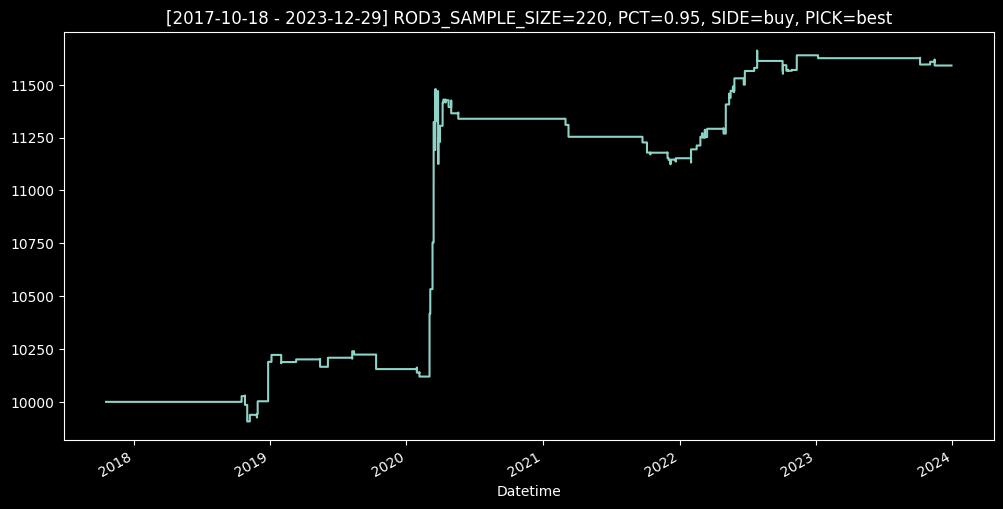

In [12]:
df = main_df[main_df.index.year < 2024].copy()

bt = Backtest(df, EndOfDayReversal_v2, trade_on_close=True)
stats = bt.run(ROD3_SAMPLE_SIZE=220, PCT=0.95, SIDE='buy', PICK = 'best')

print(stats)
title = (
    f"[{df.index[0].date()} - {df.index[-1].date()}] "
    f"ROD3_SAMPLE_SIZE={stats._strategy.ROD3_SAMPLE_SIZE}, "
    f"PCT={stats._strategy.PCT}, "
    f'SIDE={stats._strategy.SIDE}, '
    f'PICK={stats._strategy.PICK}'
)
stats._equity_curve['Equity'].plot(figsize=(12, 6), title=title)
plt.show()

This time we picked the best result because with larger number of trades we ended up being in a drawdown during the preiod from ~2020 to 2022:

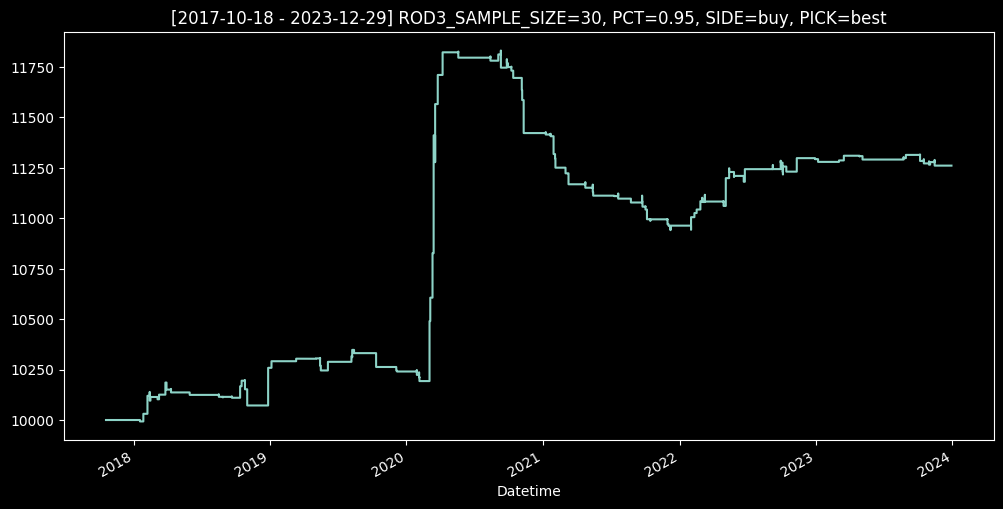

Thus, buying on the best days yields positive results, but we need to look at 95% percentile and most importantly along a broeader ROD3 observations window size.

> Of course this is over fitting, but thanks to OOS test we will see if these considerations are true.


### Combine two strategies

Before doing an out of sample test, let's combine the two positive results into a single strategy that:
1. Buys when the day ROD3 ranks above the 95% of the past 220 days observations.
2. Sell when the day ROD3 ranks below the worst 10% observations in the last 20 days.

Start                     2017-10-18 15:30:00
End                       2023-12-29 16:00:00
Duration                   2263 days 00:30:00
Exposure Time [%]                     3.34749
Equity Final [$]                     10092.85
Equity Peak [$]                      10093.82
Return [%]                             0.9285
Buy & Hold Return [%]                85.76732
Return (Ann.) [%]                     0.14941
Volatility (Ann.) [%]                 0.13505
CAGR [%]                              0.10297
Sharpe Ratio                          1.10635
Sortino Ratio                         2.07897
Calmar Ratio                          0.76723
Alpha [%]                             0.92791
Beta                                  0.00001
Max. Drawdown [%]                    -0.19474
Avg. Drawdown [%]                    -0.03856
Max. Drawdown Duration      418 days 00:00:00
Avg. Drawdown Duration       90 days 06:00:00
# Trades                                  226
Win Rate [%]                      

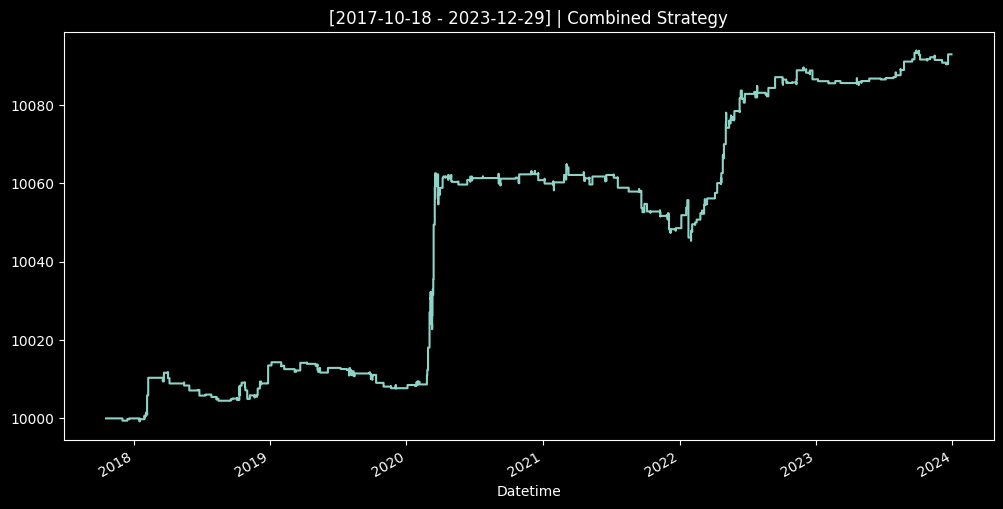

In [32]:
# Cutting out data
df = main_df[main_df.index.year < 2024].copy()

class EndOfDayReversal_v3(Strategy):

    def init(self):
        # log('=='*50+f'\n🏁 BACKTEST STARTED\nROD3_PERIOD={self.ROD3_SAMPLE_SIZE}, PCT={self.PCT}.\n')
        pass

    def next(self):
        
        today_date = self.data.index[-1]
        trade_time = today_date.strftime('%H:%M') == '15:00'
        close_time = today_date.strftime('%H:%M') == '16:00'
        
        # If it's time to buy (i.e. we have the ROD3 for the day)
        if trade_time:
            
            rod3_df = self.data.df['ROD3'].dropna().copy()

            #1. Buys when the day ROD3 ranks above the 95% of the past 220 days observations.
            if len(rod3_df) >= 220:
                
                rod3_values220 = rod3_df.tail(220).to_frame('ROD3')
                rod3_values220['rank'] = rod3_values220['ROD3'].rank(pct=True)
                today_rod3_220 = rod3_values220.loc[today_date]
                
                if today_rod3_220['rank'] >= 0.95:
                    self.buy(size=1)
                    # Don't check any further if a trade has opened
                    return
            
            #2. Sell when the day ROD3 ranks below the worst 10% observations in the last 20 days.
            if len(rod3_df) >= 20:
                
                rod3_values20 = rod3_df.tail(20).to_frame('ROD3')
                rod3_values20['rank'] = rod3_values20['ROD3'].rank(pct=True)
                today_rod3_20 = rod3_values20.loc[today_date]
                
                if today_rod3_20['rank'] <= 0.1:
                    self.sell(size=1)

        if self.position and close_time:
            self.position.close()
            

bt = Backtest(df, EndOfDayReversal_v3, trade_on_close=True)
stats = bt.run()

print(stats)
title = f"[{df.index[0].date()} - {df.index[-1].date()}] | Combined Strategy"

stats._equity_curve['Equity'].plot(figsize=(12, 6), title=title)
plt.show()

## Out of sample combined portfolio test

Start                     2017-10-18 15:30:00
End                       2025-10-10 16:00:00
Duration                   2914 days 00:30:00
Exposure Time [%]                     3.43292
Equity Final [$]                     10103.86
Equity Peak [$]                      10106.87
Return [%]                             1.0386
Buy & Hold Return [%]               155.23076
Return (Ann.) [%]                     0.12988
Volatility (Ann.) [%]                 0.14137
CAGR [%]                              0.08939
Sharpe Ratio                          0.91875
Sortino Ratio                         1.76175
Calmar Ratio                          0.54861
Alpha [%]                             1.04495
Beta                                 -0.00004
Max. Drawdown [%]                    -0.23675
Avg. Drawdown [%]                    -0.04477
Max. Drawdown Duration      432 days 00:00:00
Avg. Drawdown Duration       97 days 04:57:00
# Trades                                  298
Win Rate [%]                      

/tmp/ipykernel_343015/252424679.py:2: UserWarning: Some trades remain open at the end of backtest. Use `Backtest(..., finalize_trades=True)` to close them and include them in stats.
  stats = bt.run()


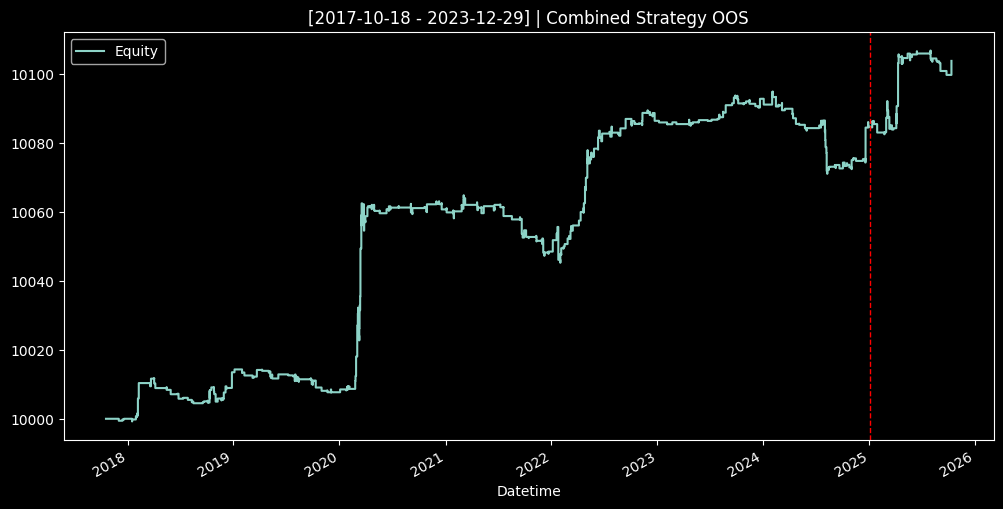

In [36]:
bt = Backtest(main_df.copy(), EndOfDayReversal_v3, trade_on_close=True)
stats = bt.run()

print(stats)
title = f"[{df.index[0].date()} - {df.index[-1].date()}] | Combined Strategy OOS"


eq_curve = stats._equity_curve['Equity'].to_frame('Equity')
# Default starting capital of the backtest is 10k
# eq_curve['Buy and Hold'] = 10_000 + (main_df['Close'] - main_df['Close'].iloc[0])
eq_curve.plot(figsize=(12, 6), title=title)
# Get the first timestamp from 2025
first_2025 = main_df.loc[main_df.index.year == 2025].index.min()
plt.axvline(first_2025, color='red', linestyle='--', linewidth=1)

plt.show()

The result persist on the OOS, which is a good sign. But it's not enough to outperform a simple buy'n hold.

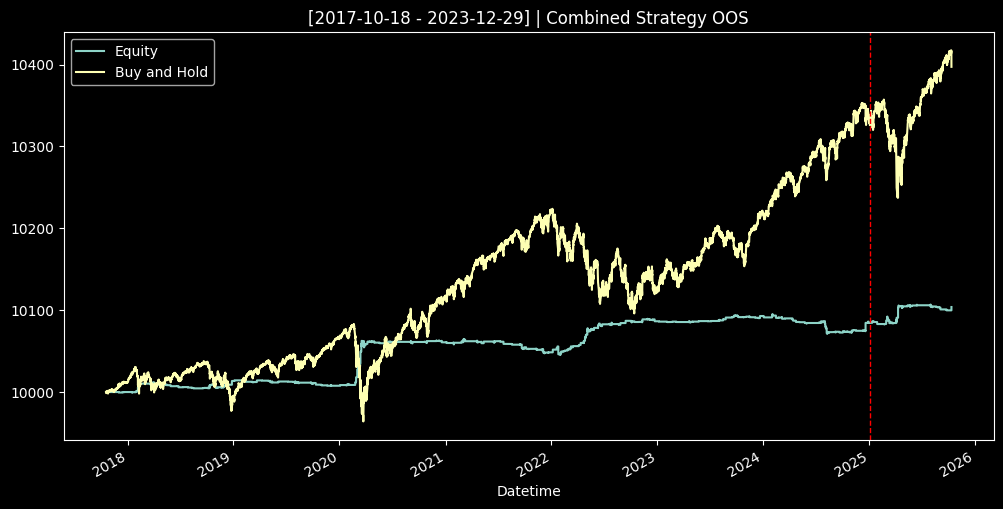


Maybe a position sizing strategy could help to bring better results, but generally the strategy underperforms the underlying.